# English Language Learning Ability Prediction Model


## Summary


In this report we attempt to build a prediction model using linear regression models to predict an individual’s English Proficiency Score based on factors such as age, education, and language background. Our final regression model used Ridge linear regression trained wth L2 regularization and was found to have an optimal alpha value of 1.546. The performance of our model was scored across two metrics - R-squared score and Root Mean Squared Error (RMSE). Our model had a R-squared value of 0.24, indicating that 24% of the variance in the correct English Proficiency Score is associated with the features in our model and our RMSE of 0.052821 suggested that, on average, our predictions have an error of 5.28%. We analyzed the learned coefficients to determine the most. Looking at our predicted scores and the associated true English Proficiency Scores, we observed that our model performed better for higher actual English Proficiency Scores. This prediction could therefore be used in an informal setting for screening of proficiency based on certain factors - where the predicted score its just used as a baseline. The model may be useful in the initial analysis of individuals wanting to learn English - for example as a tool to allocate the appropriate amount of resources or suggest a certain level of guidance to an individual to best facilitate their English learning. We also interpreted the learned coefficients for our model which found that the most important features in our dataset associated with English Proficiency Scores is the `Eng_little` encoding which indicates the individual’s current level of English (e.g., native, immersion learner, non-immersion learner).


## Introduction


### Background


In an increasingly interconnected world, the mastery of English language skills has ascended to critical importance. English frequently functions as the common medium of exchange in global commerce, education, and cross-border dialogue. This surge in demand has spurred extensive research into understanding the factors that contribute to successful English language learning. Various studies have explored a range of determinants, including age, educational background, language exposure, and the presence of learning disabilities like dyslexia.

The concept of a critical period for language acquisition, a time during which learning a language is considerably easier and more effective, has been a focal point of debate and investigation. Research in this domain often leverages extensive datasets to analyze these factors and predict language learning outcomes, providing valuable insights for educators and learners alike.

The dataset used in this study offers a rich collection of data points encompassing various demographic and linguistic variables. It includes information on native languages, the age of English language learning initiation, years spent in English-speaking environments, and the presence of psychiatric disorders or reading difficulties. This comprehensive dataset facilitates a nuanced exploration of how these diverse factors interplay to influence English language proficiency.

By employing machine learning techniques and statistical analysis, this project aims to predict an individual’s proficiency in English, contributing to the broader understanding of language acquisition and offering practical applications in educational settings.


### Research Question


Can we predict an individual's English proficiency score based on factors such as age, education, and language background?


### Dataset


The dataset is associated with the study "A Critical Period for Second Language Acquisition: Evidence from 2/3 Million English Speakers," authored by Joshua Hartshorne, Joshua Tenenbaum, and Steven Pinker, it includes demographic variables, language exposure details, and responses to critical questions. The dataset encompasses a wide range of languages, educational backgrounds, and living environments and the analysis primarily focuses on monolinguals, immersion learners, and non-immersion learners, providing valuable insights for language acquisition.

This dataset is publicly available and consists of a substantial collection of data points, totaling 671.5MB in size. The repository includes several key components:

1. **Compiled.csv**: This file contains the raw data, including subjects and items that were later excluded from the analysis.
2. **Data.csv**: This file features only the subjects and items that were analyzed in the study.
3. **Processing.R**: An R script included in the repository is used for converting data from the compiled.csv file into the format present in the data.csv file.

The dataset covers a range of variables, such as:

- **Basic Information**: Unique subject ID, date and time at the start of the experiment, gender, and age.
- **Language Details**: Native languages (natlangs), primary language currently used (primelangs), and age at which English learning started (Eng_start).
- **Living and Education Background**: Years living in English-speaking countries, living with native English speakers, highest level of education, and countries lived in.
- **Psychiatric and Reading Difficulties**: Reports of any psychiatric disorders and difficulties with reading (dyslexia).
- **Experiment-specific Information**: Use of a dictionary in the experiment, prior participation in the experiment, and percentage of critical items answered correctly.

Additionally, there are columns for responses to individual questions in the experiment. We will explore the dataset in detail below.
Note: Due to this being Milestone 1 project, we limited the analysis to 200,000 rows to ensure that the analysis would run quickly and to ensure that do not exceed the 100MB limit for simplicity. We selected the rows through random sampling ( the script used can be found as `src/random_sampling_from_full_dataset.ipynb`


## Methods and Results


In order to address our research question, we will first select the appropriate features from our dataset by way of EDA and by referring to the data dictionary to better understand the instances in the dataset ( dataset information is linked in references). Additionally, since this will be a linear regression modelling problem, we will use the `Ridge` and `Lasso` Model as our models of choice, we will assess their ability by using the $R^2$ and negative Root Mean Squared Error to ensure we use two different types of metrics to assess the variability in the predictions from the actual target.

The initial steps involved extensive data preprocessing, which included handling missing values, standardizing numerical features, and encoding categorical variables. To enhance model interpretability, we categorized education levels into major groups, consolidating less frequent categories as "Others."

We constructed a column transformer, tailored to the nature of each feature type, incorporating standard scaling for numeric attributes, one-hot encoding for categorical variables, and specific treatments for binary features. Further, a custom function was used to map less frequent education categories to an "Others" label.

The Ridge m (el, chosen as the optimodel)one, underwent hyperparameter tuning via randomized search. The performance was assessed using (negative) Root Mean Squared Error (neg-RMSE) and R-squared metrics, providing valuable insights into model accuracy and fit. The Ridge model showcased promising results, demonstrating its proficiency in predicting English proficiency scores.
To ensure the model's robustness, we validated its performance on a separate test dataset, affirming its effectiveness in predicting English proficiency scores. The final model, with an optimized alpha value of 1.546, yielded a test RMSE of 0.052821, suggesting a 5.28% average prediction error.


#### Loading Packages and Functions


In [1]:
import pandas as pd
import numpy as np
import altair as alt
import vegafusion
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    FunctionTransformer,
)
from scipy.stats import loguniform
from sklearn.linear_model import Ridge, Lasso

In [2]:
import sys
sys.path.append('..')
from src.correlation_matrix import pearson_correlation_matrix

#### Reading Data


In [3]:
# Reading the dataset

dataset = pd.read_csv(
    "../data/sampled_dataset.csv", sep=",", on_bad_lines="skip", low_memory=False
)
dataset.shape

(200849, 128)

#### Split the Dataset into Train/Test


Since we have already looked at the dataset from the source, we will be dropping some columns that increase the dimensionality of the dataset and are redundant Question level columns in the dataset that will not be used whatsoever in our dataset, we are choosing to drop those columns early on before we visualise our data and examine it for the modelling phase that will follow

Additionally since we are interested in how students perform, we do not need to consider at what time or date they took their tests hence we will drop the first 4 columns of the dataset.


In [4]:
# Creating a list of columns related to each question level data to drop
columns_to_drop = [col for col in dataset.columns if col.startswith("q")]

# Dropping the question columns from the DataFrame
dataset = dataset.drop(columns_to_drop, axis=1)

# Dropping the irrelevant columns from the DataFrame ( contain same values and do not relate to the question
dataset = dataset.drop("tests", axis=1)

# Dropping columns for ID, and index columns and additionally since we are interested in how
dataset = dataset.iloc[:, 4:]

In [5]:
# Splitting the DataFrame
train_df, test_df = train_test_split(dataset, test_size=0.3, random_state=123)

train_df.head()

,gender,age,natlangs,primelangs,dyslexia,psychiatric,education,Eng_start,Eng_country_yrs,house_Eng,...,Ir_region,UK_constituency,nat_Eng,prime_Eng,speaker_cat,type,Lived_Eng_per,Eng_little,correct,elogit
8931,male,20,Spanish,"English, Japanese, Spanish",0,0,Some Undergrad (higher ed),10,0.0,0.0,...,NaN,NaN,0,0,late,Spanish,0.0000,little,0.852632,1.726454
44135,male,21,English,English,0,0,Undergraduate Degree (3-5 years higher ed),0,NaN,NaN,...,NaN,NaN,1,1,native,United States,NaN,monoeng,0.968421,3.274446
192904,male,16,"English, Spanish","English, Spanish",0,0,Haven't Finished High School (less than 13 yea...,0,NaN,NaN,...,NaN,NaN,1,1,native,NaN,NaN,bileng,0.926316,2.468100
163907,female,19,Other,"English, Other",0,0,High School Degree (12-13 years),3,17.0,1.0,...,NaN,AL,0,0,foreign,NaN,1.0625,lot,0.968421,3.274446
147697,female,30,"English, Finnish","English, Finnish",0,0,Graduate Degree,0,NaN,NaN,...,NaN,NaN,1,1,native,NaN,NaN,bileng,0.926316,2.468100


#### EDA


Some Columns are redundant and binary versions of another column, we will exclude these from our dataset to start off, if needed we can switch to the binary version of the column later using our preprocessor


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140594 entries, 8931 to 15725
Data columns (total 28 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   gender                140594 non-null  object 
 1   age                   140594 non-null  int64  
 2   natlangs              138890 non-null  object 
 3   primelangs            138935 non-null  object 
 4   dyslexia              140594 non-null  int64  
 5   psychiatric           140594 non-null  int64  
 6   education             140594 non-null  object 
 7   Eng_start             140594 non-null  int64  
 8   Eng_country_yrs       80280 non-null   float64
 9   house_Eng             80280 non-null   float64
 10  dictionary            140594 non-null  int64  
 11  already_participated  140594 non-null  int64  
 12  countries             134387 non-null  object 
 13  currcountry           133509 non-null  object 
 14  US_region             35609 non-null   object 
 15  UK_

In [7]:
train_df.describe(include="all")

,gender,age,natlangs,primelangs,dyslexia,psychiatric,education,Eng_start,Eng_country_yrs,house_Eng,...,Ir_region,UK_constituency,nat_Eng,prime_Eng,speaker_cat,type,Lived_Eng_per,Eng_little,correct,elogit
count,140594,140594.000000,138890,138935,140594.0,140594.000000,140594,140594.000000,80280.000000,80280.000000,...,2456,19251,140594.000000,140594.000000,140594,83527,77901.000000,117214,140594.000000,140594.000000
unique,3,NaN,2399,2266,NaN,NaN,44,NaN,NaN,NaN,...,129,2250,NaN,NaN,3,54,NaN,4,NaN,NaN
top,female,NaN,English,English,NaN,NaN,Graduate Degree,NaN,NaN,NaN,...,none,none,NaN,NaN,native,United States,NaN,little,NaN,NaN
freq,75023,NaN,51933,64309,NaN,NaN,49463,NaN,NaN,NaN,...,1008,7347,NaN,NaN,62351,18216,NaN,56360,NaN,NaN
mean,NaN,29.973911,NaN,NaN,0.0,0.029873,NaN,5.211318,4.441143,0.195553,...,NaN,NaN,0.432273,0.430502,NaN,NaN,0.147289,NaN,0.937534,3.022610
std,NaN,11.253002,NaN,NaN,0.0,0.170238,NaN,5.710675,10.190303,0.396628,...,NaN,NaN,0.495394,0.495148,NaN,NaN,0.301487,NaN,0.061040,1.007372
min,NaN,7.000000,NaN,NaN,0.0,0.000000,NaN,0.000000,0.000000,0.000000,...,NaN,NaN,0.000000,0.000000,NaN,NaN,0.000000,NaN,0.063158,-2.622436
25%,NaN,22.000000,NaN,NaN,0.0,0.000000,NaN,0.000000,0.000000,0.000000,...,NaN,NaN,0.000000,0.000000,NaN,NaN,0.000000,NaN,0.915789,2.331573
50%,NaN,27.000000,NaN,NaN,0.0,0.000000,NaN,5.000000,0.000000,0.000000,...,NaN,NaN,0.000000,0.000000,NaN,NaN,0.000000,NaN,0.957895,3.012262
75%,NaN,35.000000,NaN,NaN,0.0,0.000000,NaN,10.000000,2.000000,0.000000,...,NaN,NaN,1.000000,1.000000,NaN,NaN,0.095238,NaN,0.978947,3.621671


#### Numeric Looking Columns Distribution


array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'dyslexia'}>,
        <Axes: title={'center': 'psychiatric'}>,
        <Axes: title={'center': 'Eng_start'}>],
       [<Axes: title={'center': 'Eng_country_yrs'}>,
        <Axes: title={'center': 'house_Eng'}>,
        <Axes: title={'center': 'dictionary'}>,
        <Axes: title={'center': 'already_participated'}>],
       [<Axes: title={'center': 'nat_Eng'}>,
        <Axes: title={'center': 'prime_Eng'}>,
        <Axes: title={'center': 'Lived_Eng_per'}>,
        <Axes: title={'center': 'correct'}>],
       [<Axes: title={'center': 'elogit'}>, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

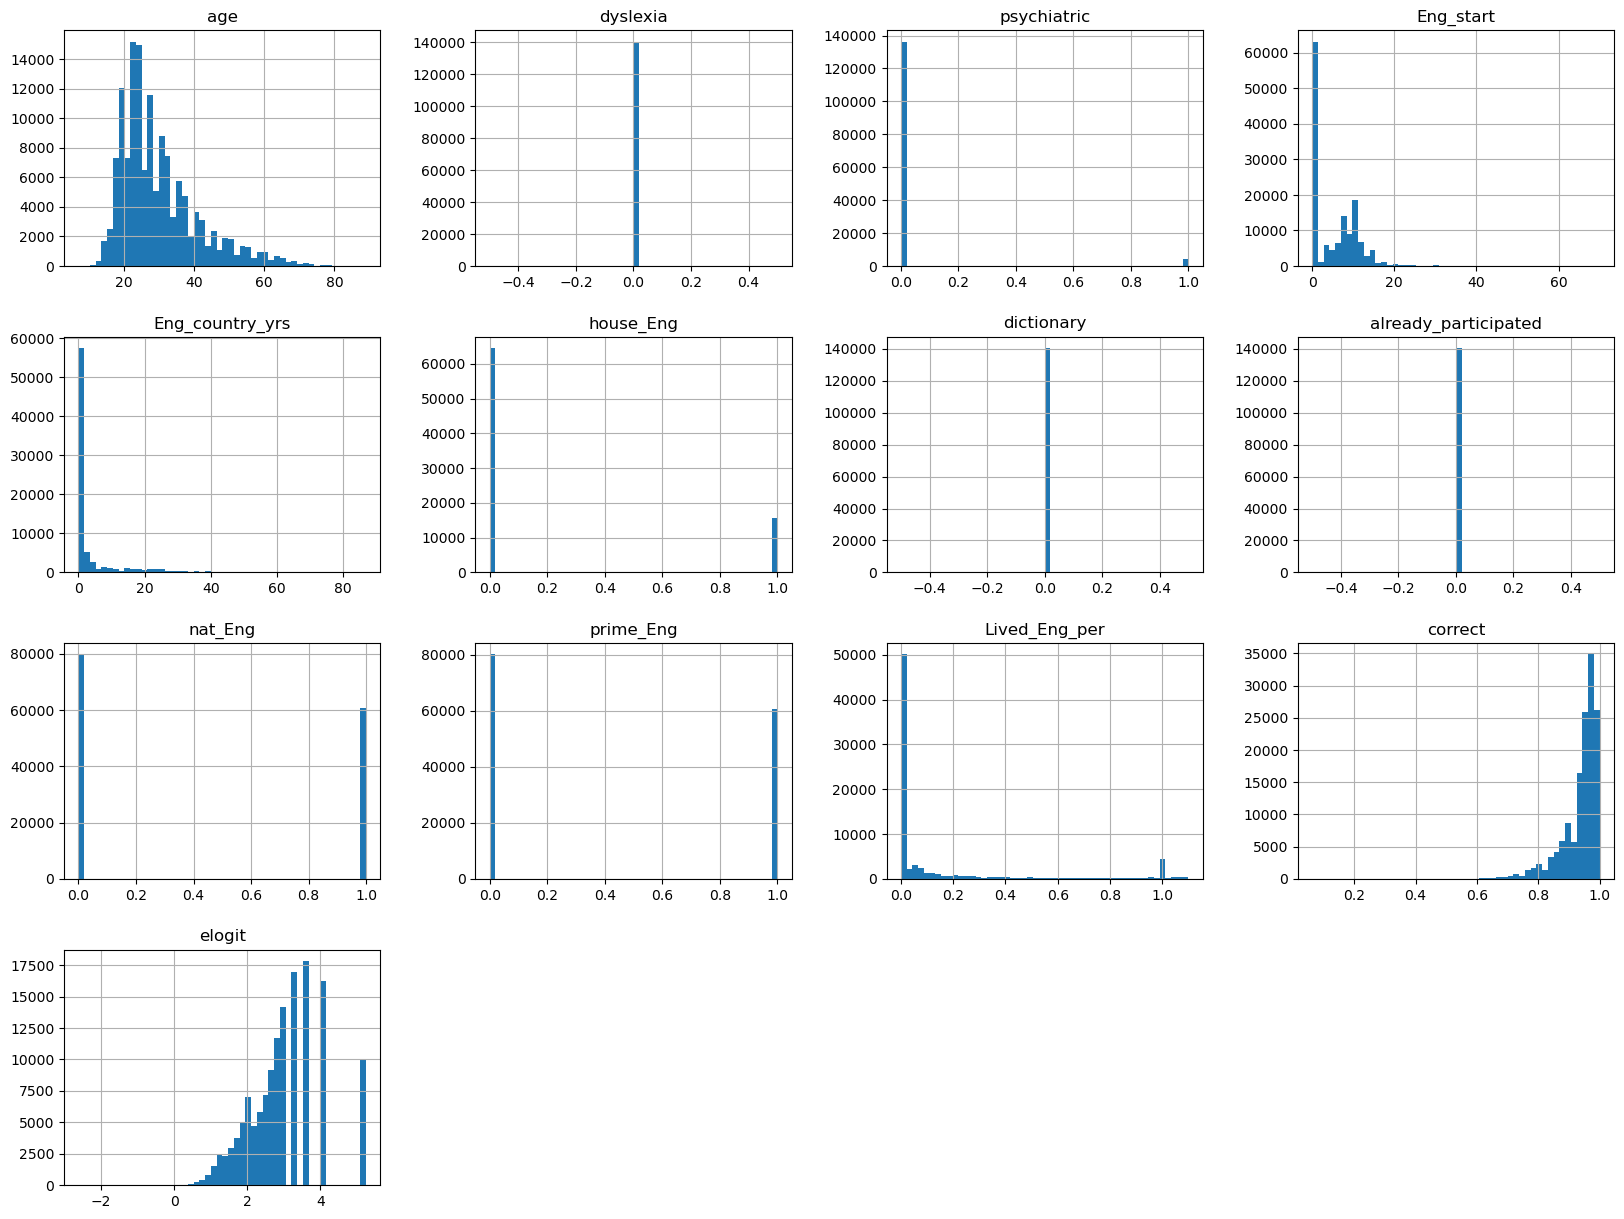

In [8]:
alt.data_transformers.enable("vegafusion")

numeric_cols = train_df.select_dtypes(include="number").columns.tolist()
train_df.hist(bins=50, figsize=(20, 15))

#### Types of Columns


In [9]:
numeric_feats = ["age", "Eng_start", "Eng_country_yrs", "Lived_Eng_per"]

binary_feats = ["house_Eng", "nat_Eng", "prime_Eng", "psychiatric"]
target = ["correct"]

Columns that can safely be dropped after looking at the distributions and looking at the data dictionary:

- `Elogit`: is the exponential log of the correct column, which would be useful for predicting probability since we would like to predict the score itself whihc is a continuous variable we can omit this from our analysis.
- `Dyslexia`: shows that all participants were not dyslexic hence there will not be any features that the model can learn so will be omitted since all values are 0
- `Dictionary`: since none of the participants used one we can safely omit this from our dataset.
- `Natlangs`: The native langs columns has a corresponding binary column which is called nat_Eng, which is a yes no column instead of the specific languages the native speakers speak. So for milestone 1 analysis we chose to omit this and go with the simple binary feature since we are interested in the English speaking ability and whether a participant had prior experience/nativity.
- `Primelangs`:same as natlangs column, we will opt for the binary column representation in the dataset.
- `Already_participated`: all values are 0 hence can be safely dropped and this feature is not of interest.
- `gender`: in order to avoid gender bias
- `type`: It is the original country where the person is from, this information is indirectly captured in the native or primary column and since we care whether the participant is from mainly English speaking vs Non English speaking we will exclude specific countries by type but keep the country column.
- We will remove the region specific information to limit the research in terms of caring whether the participant spent years in an english speaking country regardless of which country it was( dropping these columns) hence we will not consider whether a person lived in ireland or UK as long as it is english speaking so we will use columns like Eng_years as opposed to UK_region or US_region.
- `currcountry`: This column mentions the current country the participant lives in, to limit the study and reduce dimensionality we will exclude this column. Since we have other features that capture the time spent by a participant in English Speaking countries which we are more interested in. For example a native speaker who currently lives in South Africa still speaks english very well and we capture those details about them by Eng_years as opposed to where the person currently lives.
- `ebonics`: was excluded for the milestone analysis due to having additional nuances that would need to be handled ( explained later below)


In [10]:
drop_feats = [
    "elogit",
    "dyslexia",
    "dictionary",
    "already_participated",
    "natlangs",
    "primelangs",
    "Can_region",
    "Ir_region",
    "US_region",
    "UK_region",
    "UK_constituency",
    "gender",
    "type",
    "currcountry",
    "countries",
]

In [11]:
other_cols = list(
    set(train_df.columns.tolist())
    - set(numeric_feats)
    - set(binary_feats)
    - set(target)
    - set(drop_feats)
)
train_df[other_cols].describe()

,education,Ebonics,speaker_cat,Eng_little
count,140594,35591,140594,117214
unique,44,3,3,4
top,Graduate Degree,0,native,little
freq,49463,34526,62351,56360


In [12]:
drop_feats

['elogit',
 'dyslexia',
 'dictionary',
 'already_participated',
 'natlangs',
 'primelangs',
 'Can_region',
 'Ir_region',
 'US_region',
 'UK_region',
 'UK_constituency',
 'gender',
 'type',
 'currcountry',
 'countries']

In [13]:
binary_withNA = ["Ebonics"]
# The rest of the coluns are categorical
categorical_feats = list(
    set(train_df.columns.tolist())
    - set(numeric_feats)
    - set(binary_feats)
    - set(target)
    - set(drop_feats)
    - set(binary_withNA)
)
train_df[categorical_feats].head()

,education,speaker_cat,Eng_little
8931,Some Undergrad (higher ed),late,little
44135,Undergraduate Degree (3-5 years higher ed),native,monoeng
192904,Haven't Finished High School (less than 13 yea...,native,bileng
163907,High School Degree (12-13 years),foreign,lot
147697,Graduate Degree,native,bileng


In [14]:
train_df["Ebonics"].value_counts()

Ebonics
0        34526
1         1062
Array        3
Name: count, dtype: int64

#### Visualising Categorical Variables


In [15]:
chart = (
    alt.Chart(train_df)
    .mark_bar()
    .encode(
        x=alt.X("education:N", title="Education Level"),
        y=alt.Y("count():Q", title="Count"),
        tooltip=["count()"],
    )
    .properties(title="Distribution of Education Levels")
)

chart

alt.Chart(...)

In [16]:
# Get value counts for the 'education' column
education_counts = train_df["education"].value_counts()

# Filter to include only counts greater than 1
education_counts_greater_than_one = education_counts[education_counts > 100]

# Display the filtered value counts
print(education_counts_greater_than_one)

education
Graduate Degree                                         49463
Undergraduate Degree (3-5 years higher ed)              36608
Some Undergrad (higher ed)                              19577
High School Degree (12-13 years)                        16672
Some Graduate School                                    11422
Haven't Finished High School (less than 13 years ed)     5152
Didn't Finish High School (less than 13 years ed)        1634
Name: count, dtype: int64


Since majority of the Education levels are the 7 large categories, all additional Education Levels in the other categories which have a value of 1 will be labelled as Others to avoid adding major dimensionality to our dataset and we are interested in the major groups of Education Levels.


In [17]:
categorical_education = ["education"]
categorical_feats = ["Eng_little", "speaker_cat"]

In [18]:
# Checking the Categorical Features Distribution
alt.Chart(train_df, title="Distribution of the Categorical features").mark_bar().encode(
    x=alt.X(alt.repeat()),
    y="count()",
).properties(height=200, width=800).repeat(categorical_feats, columns=1)

alt.RepeatChart(...)

#### Correlation matrix

In [20]:

pearson_correlation_matrix(train_df, "seismic")

These are the selected features for the correlation matrix plot
 Index(['age', 'psychiatric', 'Eng_start', 'Eng_country_yrs', 'house_Eng',
       'nat_Eng', 'prime_Eng', 'Lived_Eng_per', 'correct', 'elogit'],
      dtype='object')


,age,psychiatric,Eng_start,Eng_country_yrs,house_Eng,nat_Eng,prime_Eng,Lived_Eng_per,correct,elogit
age,1.000000,-0.034795,0.025381,0.301947,0.102547,0.063439,0.062124,0.115234,0.102708,0.106708
psychiatric,-0.034795,1.000000,0.005652,-0.010398,0.002922,0.002231,0.001932,-0.003752,-0.108256,-0.088107
Eng_start,0.025381,0.005652,1.000000,-0.379884,-0.287491,-0.740839,-0.737942,-0.337734,-0.440083,-0.437537
Eng_country_yrs,0.301947,-0.010398,-0.379884,1.000000,0.569955,0.163828,0.163828,0.866494,0.220153,0.259877
house_Eng,0.102547,0.002922,-0.287491,0.569955,1.000000,0.118084,0.118084,0.597927,0.175287,0.208547
nat_Eng,0.063439,0.002231,-0.740839,0.163828,0.118084,1.000000,0.996396,0.138761,0.360891,0.392636
prime_Eng,0.062124,0.001932,-0.737942,0.163828,0.118084,0.996396,1.000000,0.138761,0.359188,0.390815
Lived_Eng_per,0.115234,-0.003752,-0.337734,0.866494,0.597927,0.138761,0.138761,1.000000,0.217360,0.260096
correct,0.102708,-0.108256,-0.440083,0.220153,0.175287,0.360891,0.359188,0.217360,1.000000,0.874456
elogit,0.106708,-0.088107,-0.437537,0.259877,0.208547,0.392636,0.390815,0.260096,0.874456,1.000000


There are strong negative correlations between English language-related variables `Eng_start`, `Eng_country_yrs`, `Lived_Eng_per`,`house_Eng`,`nat_Eng`,`prime_Eng`.

`correct`(our target) has a moderate positive correlation (0.103) with `age` indicating a slight positive relationship. However, this correlation is relatively weak. Additionally, correct has a strong negative correlation (-0.44) with `Eng_start`. This suggests that as the English proficiency at the start decreases, the likelihood of correctness increases.

It's important to note that correlation does not imply causation.


#### Preprocessing


##### Creating the Column Transformers


In [20]:
len(train_df.columns)

28

| Column Types            | Column Names                                                                                                                                                                                  | Preprocessing Step                                     |
| ----------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------ |
| Numeric                 | 'age', 'Eng_start', 'Eng_country_yrs', 'Lived_Eng_per'                                                                                                                                        | Standard Scaler and Fill Missing values with Median    |
| Binary                  | 'house_Eng', 'nat_Eng', 'prime_Eng', 'psychiatric'                                                                                                                                            | Keep as is                                             |
| Target                  | 'correct'                                                                                                                                                                                     | Target Column to be kept as is for now                 |
| Drop                    | 'elogit', 'dyslexia', 'dictionary', 'already_participated', 'natlangs', 'primelangs', 'Can_region', 'Ir_region', 'US_region', 'UK_region', 'UK_constituency', 'gender', 'type', 'currcountry' | Drop Columns                                           |
| Binary with NA          | 'Ebonics'                                                                                                                                                                                     | Fill Missing values with 0                             |
| Categorical - Education | 'education' (7 major categories and Others)                                                                                                                                                   | Categories other than the main 7 to be moved to Others |
| Categorical             | 'Eng_little', 'speaker_cat', 'countries'                                                                                                                                                      | One hot encoding the Categorical column                |
| Categorical - Countries | 'countries' (Map to continent)                                                                                                                                                                | Map the countries to their continents                  |


For the current scope of this analysis, we are not including "Ebonics". This is because it is an "object" datatype. We will add it in our future analysis.


In [21]:
numeric_feats = ["age", "Eng_start", "Eng_country_yrs", "Lived_Eng_per"]

binary_feats = ["psychiatric"]
target = ["correct"]

drop_feats = [
    "elogit",
    "dyslexia",
    "dictionary",
    "already_participated",
    "natlangs",
    "primelangs",
    "Can_region",
    "Ir_region",
    "US_region",
    "UK_region",
    "UK_constituency",
    "gender",
    "type",
    "currcountry",
    "countries",
]
binary_withNA = [
    "house_Eng",
    "nat_Eng",
    "prime_Eng",
]  # ["Ebonics", "house_Eng", "nat_Eng", "prime_Eng"]

categorical_education = ["education"]  # show 7 major categories and Others
categorical_feats = ["Eng_little", "speaker_cat"]
# categorical_countries = ['countries']

In [22]:
numeric_transformer = make_pipeline(
    SimpleImputer(strategy="median"), StandardScaler())

categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="little"),
    OneHotEncoder(handle_unknown="ignore", sparse_output=False),
)

binary_NA_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value=0),
    OneHotEncoder(
        handle_unknown="ignore", sparse_output=False, drop="if_binary", dtype=int
    ),
)


categories_list = education_counts_greater_than_one.index.tolist()


# Define the custom function to map values to 'Other'
def map_to_other(df):
    return (
        df["education"].apply(
            lambda x: x if x in categories_list else "Others")
    ).to_frame()


# Defines the order for Education to be used in the OrdinalEncoder
education_order = [
    "Graduate Degree",
    "Some Graduate School",
    "Undergraduate Degree (3-5 years higher ed)",
    "Some Undergrad (higher ed)",
    "High School Degree (12-13 years)",
    "Haven't Finished High School (less than 13 years ed)",
    "Didn't Finish High School (less than 13 years ed)",
    "Others",
]


# Create a transformer using FunctionTransformer
categorical_education_tranformer = make_pipeline(
    FunctionTransformer(map_to_other), OrdinalEncoder(
        categories=[education_order])
)


preprocessor = make_column_transformer(
    ("drop", drop_feats),
    (numeric_transformer, numeric_feats),
    (categorical_transformer, categorical_feats),
    ("passthrough", binary_feats),
    # ("passthrough", target),# for now it is pass through but later most likely log transformation will be applied hence added like this
    (binary_NA_transformer, binary_withNA),
    (categorical_education_tranformer, categorical_education),
)

In [23]:
map_to_other(train_df[categorical_education])

,education
8931,Some Undergrad (higher ed)
44135,Undergraduate Degree (3-5 years higher ed)
192904,Haven't Finished High School (less than 13 yea...
163907,High School Degree (12-13 years)
147697,Graduate Degree
...,...
119906,Undergraduate Degree (3-5 years higher ed)
192476,Graduate Degree
17730,Undergraduate Degree (3-5 years higher ed)
28030,Some Graduate School


In [24]:
X_train = train_df.drop(columns=target)
y_train = train_df["correct"]

X_test = test_df.drop(columns=target)
y_test = test_df["correct"]

In [25]:
check = (
    drop_feats
    + target
    + numeric_feats
    + binary_feats
    + drop_feats
    + binary_withNA
    + categorical_education
    + categorical_feats
)

In [26]:
preprocessor.fit(X_train)  # Calling fit to examine all the transformers.
preprocessor.named_transformers_

{'drop': 'drop',
 'pipeline-1': Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                 ('standardscaler', StandardScaler())]),
 'pipeline-2': Pipeline(steps=[('simpleimputer',
                  SimpleImputer(fill_value='little', strategy='constant')),
                 ('onehotencoder',
                  OneHotEncoder(handle_unknown='ignore', sparse_output=False))]),
 'passthrough': 'passthrough',
 'pipeline-3': Pipeline(steps=[('simpleimputer',
                  SimpleImputer(fill_value=0, strategy='constant')),
                 ('onehotencoder',
                  OneHotEncoder(drop='if_binary', dtype=<class 'int'>,
                                handle_unknown='ignore', sparse_output=False))]),
 'pipeline-4': Pipeline(steps=[('functiontransformer',
                  FunctionTransformer(func=<function map_to_other at 0x15995e4d0>)),
                 ('ordinalencoder',
                  OrdinalEncoder(categories=[['Graduate Degree',
                      

##### Checking if the Preprocessor Works

In [27]:
ohe_columns = list(
    preprocessor.named_transformers_["pipeline-2"]
    .named_steps["onehotencoder"]
    .get_feature_names_out(categorical_feats)
)

new_columns = (
    numeric_feats + ohe_columns + binary_feats +
    binary_withNA + categorical_education
)

In [28]:
X_train_enc = pd.DataFrame(
    preprocessor.transform(X_train), index=X_train.index, columns=new_columns
)
X_train_enc.head(5)

,age,Eng_start,Eng_country_yrs,Lived_Eng_per,Eng_little_bileng,Eng_little_little,Eng_little_lot,Eng_little_monoeng,speaker_cat_foreign,speaker_cat_late,speaker_cat_native,psychiatric,house_Eng,nat_Eng,prime_Eng,education
8931,-0.886337,0.838552,-0.316680,-0.345725,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0
44135,-0.797471,-0.912560,-0.316680,-0.345725,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,2.0
192904,-1.241798,-0.912560,-0.316680,-0.345725,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,5.0
163907,-0.975202,-0.387227,1.806243,4.155322,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0
147697,0.002318,-0.912560,-0.316680,-0.345725,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0


In [29]:
X_train_enc.isnull().values.any()

False

In [30]:
X_train_enc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140594 entries, 8931 to 15725
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   age                  140594 non-null  float64
 1   Eng_start            140594 non-null  float64
 2   Eng_country_yrs      140594 non-null  float64
 3   Lived_Eng_per        140594 non-null  float64
 4   Eng_little_bileng    140594 non-null  float64
 5   Eng_little_little    140594 non-null  float64
 6   Eng_little_lot       140594 non-null  float64
 7   Eng_little_monoeng   140594 non-null  float64
 8   speaker_cat_foreign  140594 non-null  float64
 9   speaker_cat_late     140594 non-null  float64
 10  speaker_cat_native   140594 non-null  float64
 11  psychiatric          140594 non-null  float64
 12  house_Eng            140594 non-null  float64
 13  nat_Eng              140594 non-null  float64
 14  prime_Eng            140594 non-null  float64
 15  education           

### Modeling & Results

As discussed in the Methods summary, we will now build and test our Ridge Regression and Lasso Models


##### Ridge Regression Model

In this section we will be using the Ridge Regression model to predict the English Proficiency Score of a participant based on the features we have selected in the previous section.

Ridge regression is a linear regression model that uses L2 regularization. This means that the model penalizes the sum of squared coefficients.

We will use the RMSE for our metric of choice to evaluate the performance of our model. This is because it would give us the same units as our target variable and would be easier to interpret. We considered using MAPE as well but since we have some values that are 0 in our target variable, we would have to drop those values and we would lose some information. We also included the R squared (the score that sklearn uses by default when you call score) in our CV results to have another, maybe more intuitive, way of assessing our model performance. Note that we set `refit='RMSE'` so that our best model that is returned has an alpha value that has the best cross-validated RMSE score.


In [31]:
# Make the pipeline
ridge_pipe = make_pipeline(preprocessor, Ridge())

# Create the parameter grid
param_grid = {
    "ridge__alpha": loguniform(1e-3, 1e3),
}

# Make scoring list
scoring = {"RMSE": "neg_root_mean_squared_error", "R squared": "r2"}

ridge_search = RandomizedSearchCV(
    ridge_pipe,
    param_distributions=param_grid,
    n_jobs=-1,
    n_iter=30,
    cv=10,
    return_train_score=True,
    random_state=123,
    scoring=scoring,
    refit="RMSE",
)

ridge_search.fit(X_train, y_train)

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('drop',
                                                                               'drop',
                                                                               ['elogit',
                                                                                'dyslexia',
                                                                                'dictionary',
                                                                                'already_participated',
                                                                                'natlangs',
                                                                                'primelangs',
                                                                                'Can_region',
                                                                                'Ir_region',
                                                                                'US_region',
                                                                                'UK_region',
                                                                                'UK_constituency',
                                                                                'gender',
                                                                                'type',
                                                                                'currcountry',
                                                                                'countries']),
                                                                              ('pipeline-1',
                                                                               Pipeline(steps=[('simplei...
                                                                                                                            'Finish '
                                                                                                                            'High '
                                                                                                                            'School '
                                                                                                                            '(less '
                                                                                                                            'than '
                                                                                                                            '13 '
                                                                                                                            'years '
                                                                                                                            'ed)',
                                                                                                                            'Others']]))]),
                                                                               ['education'])])),
                                             ('ridge', Ridge())]),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'ridge__alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x15a39fc40>},
                   random_state=123, refit='RMSE', return_train_score=True,
                   scoring={'R squared': 'r2',
                            'RMSE': 'neg_root_mean_squared_error'})

The cell below shows the top 5 alpha values and their corresponding scores.


In [32]:
pd.DataFrame(ridge_search.cv_results_)[
    [
        "rank_test_R squared",
        "param_ridge__alpha",
        "mean_train_RMSE",
        "mean_train_R squared",
        "mean_test_RMSE",
        "mean_test_R squared",
        "mean_fit_time",
        "rank_test_RMSE",
    ]
].set_index("rank_test_RMSE").sort_index().head(5).T

rank_test_RMSE,1,2,3,4,5
rank_test_R squared,1,2,3,5,4
param_ridge__alpha,1.546352,1.552264,0.768407,0.42799,2.031836
mean_train_RMSE,-0.053173,-0.053173,-0.053173,-0.053173,-0.053173
mean_train_R squared,0.241154,0.241154,0.241154,0.241154,0.241154
mean_test_RMSE,-0.053178,-0.053178,-0.053178,-0.053178,-0.053178
mean_test_R squared,0.240958,0.240958,0.240958,0.240958,0.240958
mean_fit_time,0.203075,0.201432,0.202456,0.206245,0.210324


In [33]:
best_ridge_alpha = ridge_search.best_params_["ridge__alpha"]
print(f"Best alpa for Ridge: {best_ridge_alpha}")
print(f"Best CV RMSE score: {-ridge_search.best_score_}")

Best alpa for Ridge: 1.5463515822289584
Best CV RMSE score: 0.05317798805753665


In [34]:
print(f"Test RMSE score: {-ridge_search.score(X_test, y_test)}")

Test RMSE score: 0.052821373332525325


We find out that the optimal `alpha` value for ridge is 1.546. This corresponds to a CV RMSE of 0.053178 and a test score of 0.052821. We should note that this alpha value is optimal for both RMSE and $R^2$ - maximizing the $R^2$ CV score to 0.24096.

This shows that the model is not overfitting since the CV and test scores are very close to each other (both rounding to 5.3%).


##### Lasso Regression Model

The next model that we created is a Lasso Regression model. Lasso stands for Least Absolute Shrinkage and Selection Operator and differs from Ridge Regression in that Lasso allows for feature reduction (i.e. the coefficients can be zero whereas Ridge never sets the coefficient to be zero). Like Ridge, Lasso is a linear regression model, but uses L1 regularization - penalizing the sum of the absolute values of the coefficients. Similar to the Ridge Regression modeling above, we performed 10-fold cross-validation using RMSE as our primary scoring metric.


In [35]:
# Set alphas to search over for Lasso
lasso_dist = {"lasso__alpha": loguniform(1e-3, 1e3)}

# Make the Lasso pipeline & search best alpha
lasso_pipe = make_pipeline(preprocessor, Lasso())
lasso_search = RandomizedSearchCV(
    lasso_pipe,
    param_distributions=lasso_dist,
    n_jobs=-1,
    n_iter=30,
    cv=10,
    return_train_score=True,
    random_state=123,
    scoring=scoring,
    refit="RMSE",
)

lasso_search.fit(X_train, y_train)

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('drop',
                                                                               'drop',
                                                                               ['elogit',
                                                                                'dyslexia',
                                                                                'dictionary',
                                                                                'already_participated',
                                                                                'natlangs',
                                                                                'primelangs',
                                                                                'Can_region',
                                                                                'Ir_region',
                                                                                'US_region',
                                                                                'UK_region',
                                                                                'UK_constituency',
                                                                                'gender',
                                                                                'type',
                                                                                'currcountry',
                                                                                'countries']),
                                                                              ('pipeline-1',
                                                                               Pipeline(steps=[('simplei...
                                                                                                                            'Finish '
                                                                                                                            'High '
                                                                                                                            'School '
                                                                                                                            '(less '
                                                                                                                            'than '
                                                                                                                            '13 '
                                                                                                                            'years '
                                                                                                                            'ed)',
                                                                                                                            'Others']]))]),
                                                                               ['education'])])),
                                             ('lasso', Lasso())]),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'lasso__alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x15a3a6410>},
                   random_state=123, refit='RMSE', return_train_score=True,
                   scoring={'R squared': 'r2',
                            'RMSE': 'neg_root_mean_squared_error'})

Below are the results of our randomized hyperparameter search for the top 5 alpha values and the corresponding RMSE scores and fit times.


In [36]:
pd.DataFrame(lasso_search.cv_results_)[
    [
        "rank_test_R squared",
        "param_lasso__alpha",
        "mean_train_RMSE",
        "mean_train_R squared",
        "mean_test_RMSE",
        "mean_test_R squared",
        "mean_fit_time",
        "rank_test_RMSE",
    ]
].set_index("rank_test_RMSE").sort_index().head(5).T

rank_test_RMSE,1,2,3,4,5
rank_test_R squared,1,2,3,4,5
param_lasso__alpha,0.002281,0.01129,0.012444,0.022967,0.02342
mean_train_RMSE,-0.054163,-0.055962,-0.056206,-0.059428,-0.059605
mean_train_R squared,0.212617,0.159462,0.152115,0.052097,0.046466
mean_test_RMSE,-0.054164,-0.055961,-0.056205,-0.059428,-0.059604
mean_test_R squared,0.212556,0.159434,0.152086,0.052057,0.046424
mean_fit_time,0.224467,0.21314,0.217945,0.215921,0.20851


In [37]:
print(f"Best alpha value for Lasso: {lasso_search.best_params_['lasso__alpha']}")
print(f"Best CV RMSE score for Lasso: {-lasso_search.best_score_}")

Best alpha value for Lasso: 0.002280695888578119
Best CV RMSE score for Lasso: 0.054163949024438815


Now that we have found this optimal model, we can score this model to our test data.


In [38]:
print(f"Test RMSE score: {-lasso_search.score(X_test, y_test)}")

Test RMSE score: 0.05386423384869615


For our optimal model with an `alpha` value of 0.002281, we got a CV RMSE of 0.05416 for our training data and a RMSE test score of 0.05386. Like in our Ridge model, we find again that our model is not overfitting since the CV train score and test score are very similar (both rounding to 5.4%). Likee Ridge, we note again that this alpha value is optimal for both RMSE and $R^2$ - maximizing the $R^2$ CV score to 0.21256.


##### Model Selection

The CV RMSE and test score results from the Ridge and Lasso models detailed above are very similar, however the optimal Ridge model performs marginally better on both the training and test data (with roughly a 5.3% RMSE on both training and test data). Therefore, our optimal model is the `Ridge` linear model trained with L2 regularization and an `alpha` value of 1.546.


## Discussion

Looking at our optimal model, we are able to look at the learned coefficients for the model features. We interpret our results in that increasing features with positive coefficients is associated with an increased `correct` test score, whereas an increase in the features with negative coefficients is associated with decreasing `correct` test scores.


In [39]:
# Checking the learned coefficients
best_pipe = make_pipeline(
    preprocessor, Ridge(alpha=ridge_search.best_params_["ridge__alpha"])
)
best_pipe.fit(X_train, y_train)

# Get the feature names from the preprocessor
best_pipe_coeffs = best_pipe.named_steps["ridge"].coef_
pd.DataFrame(
    data=best_pipe_coeffs, index=X_train_enc.columns, columns=["Coefficients"]
).sort_values(by="Coefficients", ascending=False)

,Coefficients
Eng_little_monoeng,0.038274
Eng_little_bileng,0.033161
speaker_cat_late,0.010343
house_Eng,0.008453
speaker_cat_foreign,0.007181
Lived_Eng_per,0.006952
age,0.003894
Eng_country_yrs,0.001612
prime_Eng,-0.001772
education,-0.002058


From the results above, we can see that the most important features in determining a high English Proficiency Score are:

- `Eng_little_monoeng`: This is a binary column that indicates whether the participant is a native speaker of English or not. This is the most important feature associated with increasing the English Proficiency Score.
- `Eng_little_bileng`: This is a binary column that indicates whether the participant is native speaker of English plus at least one other language. This is the second most important feature associated with increasing the English Proficiency Score.

This shows that the most important feature in increasing the English Proficiency Score among this dataset is whether the participant is a native speaker of English or not. This is followed by whether the participant is a native speaker in both English and at least one other language - both of which make sense logically.

The most important features in lowering the English Proficiency Score are:

- `Eng_little_lot`: This is a binary column that indicates whether the participant is an immersion learner.
- `psychiatric`: This is a binary column that indicates whether the participant has any psychiatric disorders.
- `Eng_little_little`: This is a binary column that indicates whether the participant is a non-immersion learner.

This somewhat makes sense since the most important features in determining the test scores is the Eng_little encoding. If the person is a native speaker or a native speaker of English and at least one other language, they would have a higher test score. If the person is an immersion learner or a non-immersion learner, they would have a lower test score.


We measured the performance of our model on the test data with our RMSE test score of 0.052821 (~ 5.28%) (and a corresponding $R^2$ score of 0.24096). From these numbers, we can make a couple general notes on our model performance. Our $R^2$ value of 0.24 means that 24% of the variance in the `correct` English Proficiency Score is associated with the features (as illustrated in our coefficient table above) in our model. Additionally, our RMSE of 0.052821 suggests that, on average, our predictions have an error of 5.28%. We can further visualize the deviation of our predictions from the actual test scores by plotting our predicted test English Proficiency Score values against our actual test English Proficiency Score values.


Text(0.5, 1.0, 'Actual vs. Predicted English Proficiency Score for Ridge Model\n(Test Data)')

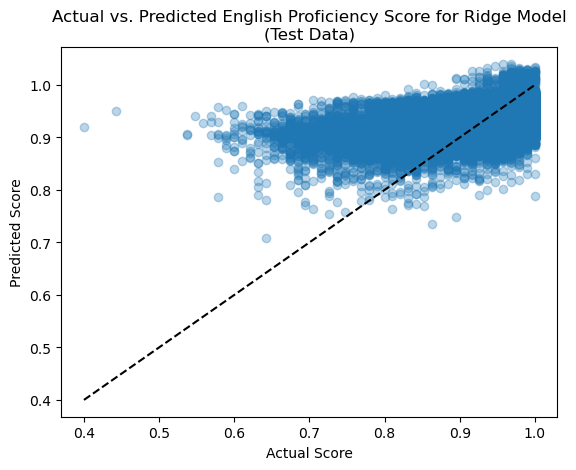

In [40]:
plt.scatter(y_test, ridge_search.predict(X_test), alpha=0.3)
grid = np.linspace(y_test.min(), y_test.max(), 1000)
plt.plot(grid, grid, "--k")
plt.xlabel("Actual Score")
plt.ylabel("Predicted Score")
plt.title("Actual vs. Predicted English Proficiency Score for Ridge Model\n(Test Data)")

The scatterplot above plots our predicted English Proficiency Scores from our Ridge model against the actual English Proficiency Scores. The dashed black line represents the "perfect" prediction where the predicted is equal to the actual score. We see that the majority of the examples are clustered in the upper right quadrant of the plot and appear to be closer to the diagonal line, veering further above the diagonal as the actual score value decreases. This indicates that the predicted scores are more accurate for the higher actual scores, and we tend to predict higher scores as the value of the actual score decreases. Although our 5.3% RMSE quantifies our model performance in general, we can note from the plot above that our model appears to better predict higher English Proficiency Scores - varying significantly from the actual score for lower English Proficiency Scores.


Considering the limitations noted above, our model may be useful in the initial analysis of individuals wanting to learn English as a second language to make an informal prediction on an estimated level of English Proficiency. This estimated English Proficiency Score could be used as a tool to allocate the appropriate amount of resources or suggest a certain level of guidance to an individual to best facilitate their English learning. This work could be further explored with a more in depth look at the feature importance and the correlation between specific features in the dataset and how they are associated with test scores. This could also be improved with feature selection to see which combination os features would be best used to help the model better predict test scores. Additionally, other regression models could be explored, such as KNN regression, to see if allowing for non-linear decision boundaries


## References

Hartshorne, J. (2020, September 30). Data: A critical period for second language acquisition: Evidence from 2/3 million English speakers. OSF. https://osf.io/pyb8s/wiki/home/ (Dataset)

Hartshorne, J. K., Tenenbaum, J. B., &amp; Pinker, S. (2018). A critical period for second language acquisition: Evidence from 2/3 million English speakers. Cognition, 177, 263–277. https://doi.org/10.1016/j.cognition.2018.04.007

Li, H. L. and M. (2023a, April 18). Practitioner’s Guide to Data Science. 10.2 LASSO. https://scientistcafe.com/ids/lasso

Wessel N. van Wieringen1 Department of Epidemiology and Data Scienc. eLecture notes on ridge regression (Version 0.60, June 27, 2023.) https://arxiv.org/pdf/1509.09169.pdf

Deepika Singh (Nov 12, 2019) Linear, Lasso, and Ridge Regression with R https://www.pluralsight.com/guides/linear-lasso-and-ridge-regression-with-r
